# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В архиве есть следующие данные:   
Признаки   
DateCrawled — дата скачивания анкеты из базы   
VehicleType — тип автомобильного кузова   
RegistrationYear — год регистрации автомобиля   
Gearbox — тип коробки передач   
Power — мощность (л. с.)   
Model — модель автомобиля   
Kilometer — пробег (км)   
RegistrationMonth — месяц регистрации автомобиля   
FuelType — тип топлива   
Brand — марка автомобиля   
Repaired — была машина в ремонте или нет   
DateCreated — дата создания анкеты   
NumberOfPictures — количество фотографий автомобиля   
PostalCode — почтовый индекс владельца анкеты (пользователя)   
LastSeen — дата последней активности пользователя   
Целевой признак   
Price — цена (евро)   

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv("autos.csv")
except:
    print('could not open the file')
data.head()
data.duplicated().sum()

4

уберем дубликаты

In [3]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Для дальнейшей работы стобцы DateCrawled, NumberOfPictures, PostalCode, LastSeen считаю неинформативными, удалю их

In [4]:
data = data.drop(['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [5]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           283211 non-null  object
 11  DateCreated        354365 non-null  object
dtypes: int64(5), object(7)
memory usage: 35.1+ MB


In [7]:
data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
dtype: int64

Пропусков в столбце "цена" нет, попробуем посмотреть на диапазон значений

In [8]:
data.sort_values(by = 'Price', ascending = True)['Price'].unique()[:100]

array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  24,  25,  26,  27,  29,
        30,  32,  33,  35,  38,  39,  40,  45,  47,  49,  50,  55,  58,
        59,  60,  65,  66,  69,  70,  74,  75,  77,  79,  80,  85,  88,
        89,  90,  95,  98,  99, 100, 101, 105, 106, 108, 110, 111, 112,
       115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130,
       132, 133, 135, 139, 140, 142, 145, 149, 150, 155, 156, 157, 158,
       159, 160, 162, 165, 166, 169, 170, 173, 175])

array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

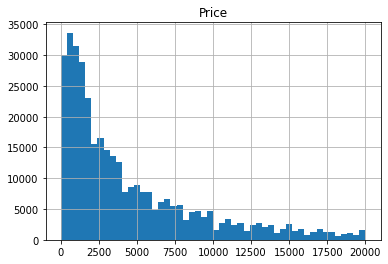

In [9]:
data.hist('Price', bins = 50)

У нас много машин с подозрительно низкой ценой, включая бесплатные. Думаю, стоит удалить данные с машинами, дешевле 100. Верхняя граница выглядит вполне убедительно

In [10]:
data.drop(index=data.query('Price<100').index, inplace = True)

In [11]:
data['VehicleType'].isna().sum()/(len(data['VehicleType']))*100

9.5622062389496

Пропусков в "VehicleType" почти 10%, удалять не стоит, заменять чем-нибудь средним тоже будет некорректно. Заменю на 'unknown'

In [12]:
data['VehicleType'] = data['VehicleType'].fillna("unknown")
data['VehicleType'].isna().sum()

0

Разберём столбец 'RegistrationYear'. Здесь отсутствуют пропуски. Посмотрим на значения

In [13]:
data.sort_values(by = 'RegistrationYear', ascending = True)['RegistrationYear'].unique()[:15]

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925])

In [14]:
data.sort_values(by = 'RegistrationYear', ascending = False)['RegistrationYear'].unique()[:30]

array([9999, 9450, 9000, 8888, 8500, 8200, 7800, 7100, 7000, 6000, 5911,
       5900, 5600, 5555, 5300, 5000, 4800, 4500, 4100, 4000, 3800, 3700,
       3200, 3000, 2900, 2800, 2500, 2290, 2222, 2200])

In [15]:
len(data.loc[(data['RegistrationYear']<1880)|(data['RegistrationYear']>2023)])/len(data['RegistrationYear'])*100

0.03371929711392138

Как видим, у нас есть в наличии машины из будущего и глубокого прошого. Но хорошо, что их совсем немного. Значит можно их удалить

In [16]:
data.drop(index = data.query(('RegistrationYear<1880')).index, inplace = True)
data.drop(index = data.query(('RegistrationYear>2023')).index, inplace = True)

Много пропусков в столбце, отвечающем за коробку передач. Заменю наиболее популярным значением по модели. Поскольку в модели у нас тоже пропуски, а восстанавливать их будет некорректно, то сначала удалим строки с пропусками по модели

In [17]:
data.dropna(subset=['Model'], inplace=True)
data['Model'].isna().sum()

0

In [18]:
data['Gearbox'] = data['Gearbox'].fillna(data.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))
data['Gearbox'].isna().sum()

0

In [19]:
data.sort_values(by = 'Power', ascending = False)['Power'].unique()

array([20000, 19312, 19211, 19208, 17932, 17700, 17410, 17019, 17011,
       16312, 16311, 16011, 15033, 15020, 15017, 15001, 13636, 13616,
       12512, 12510, 12012, 11635, 11530, 11509, 11111, 11025, 11011,
       10710, 10522, 10520, 10311, 10218, 10110,  9013,  9012,  9011,
        9007,  9000,  8500,  8404,  8259,  7544,  7529,  7518,  7515,
        7512,  7511,  7508,  6920,  6512,  6226,  6062,  6045,  6018,
        6012,  6011,  6010,  6006,  5867,  5815,  5809,  5575,  5420,
        5411,  4700,  4507,  4400,  3750,  3500,  3454,  3199,  2799,
        2792,  2789,  2729,  2598,  2461,  2402,  2331,  2172,  2018,
        2017,  2016,  2009,  2007,  2005,  2000,  1999,  1998,  1995,
        1993,  1992,  1988,  1986,  1968,  1937,  1933,  1920,  1900,
        1896,  1895,  1870,  1800,  1799,  1796,  1793,  1783,  1781,
        1780,  1779,  1771,  1753,  1707,  1704,  1703,  1701,  1700,
        1689,  1659,  1653,  1631,  1625,  1600,  1598,  1597,  1595,
        1548,  1521,

Как видим, диапазон мощности широкий. Возьмем за минимум модель Benz Patent Motorwagen, мощностью 1лс, а за максимум самую мощную на данный момент Hennessey Venom F5, мощностью 1600 лс. Посмотрим, сколько у нас некорректных значений 

In [20]:
len(data.loc[(data['Power']<1)|(data['Power']>1600)])/len(data['Power'])*100

9.412814244085544

Многовато, но меньше 10%. Можно было бы заменить на медианное значение по модели, но у одной и той же модели может несколько вариантов мощности и этот параметр сильно влияет на формирование цены. Так что, пожалуй, лучше удалить.

In [21]:
data.drop(index = data.query('Power>1600').index, inplace = True)
data.drop(index = data.query('Power<1').index, inplace =True)

array([[<AxesSubplot:title={'center':'Kilometer'}>]], dtype=object)

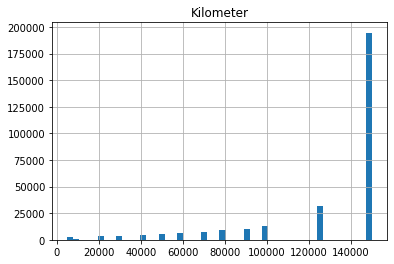

In [22]:
data.hist('Kilometer', bins = 50)

In [23]:
data.sort_values(by = 'Kilometer', ascending = True)['Kilometer'].unique()[:30]

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

Здесь всё в порядке. Пропусков нет, все значения адекватные.

В столбце "FuelType" много пропусков. Можно заменить средним по модели

In [24]:
data['FuelType'] = data['FuelType'].fillna(data.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

In [25]:
data['FuelType'] = data['FuelType'].fillna(data.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

Много пропусков в столбце "Repaired". Логично предположить, что не заполняли его в том случае, если автомобиль не ремонтировали. 

In [26]:
data['Repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

Заменю nan на 'no'

In [27]:
data['Repaired'].fillna('no', inplace=True)

In [28]:
latest = data.sort_values(by ='DateCreated')['DateCreated'].unique()[-1:]
latest

array(['2016-04-07 00:00:00'], dtype=object)

Похоже, период создания объявлений охватывает два года. Каких-либо необычных дат не замечаю. Пропусков в этом столбце нет. Заменим строковые данные на время.

In [29]:
try:
    data['DateCreated'] = pd.to_datetime(data['DateCreated'], format="%Y-%m-%d %H:%M:%S")
except:
    print('failed date_created')

Столбец "DataCreated" лучше представить в виде количества дней

In [30]:
earliest = pd.Timestamp(min(data['DateCreated']))

In [31]:
data['DateCreated'] = data['DateCreated'].map(lambda date : (pd.Timestamp(date) - earliest).days)
data['DateCreated']

2         360
3         363
4         377
5         381
6         378
         ... 
354361    355
354362    365
354366    351
354367    365
354368    366
Name: DateCreated, Length: 293459, dtype: int64

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293459 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              293459 non-null  int64 
 1   VehicleType        293459 non-null  object
 2   RegistrationYear   293459 non-null  int64 
 3   Gearbox            293459 non-null  object
 4   Power              293459 non-null  int64 
 5   Model              293459 non-null  object
 6   Kilometer          293459 non-null  int64 
 7   RegistrationMonth  293459 non-null  int64 
 8   FuelType           293459 non-null  object
 9   Brand              293459 non-null  object
 10  Repaired           293459 non-null  object
 11  DateCreated        293459 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 29.1+ MB


Теперь надо разбить данные на target и features. Данные нужно разбить на три части: обучающую, валидационную и тестовую.
Разобъем исходные данные в соотношении 3:1:1, сделав тестовый и валидационный наборы одинакового размера.

In [33]:
random = 12345
data_train, data_test_valid = train_test_split(data, test_size = 0.4, random_state = random)
features_train = data_train.drop('Price', axis = 1)
target_train = data_train['Price']
features_test_valid = data_test_valid.drop('Price', axis = 1)
target_test_valid = data_test_valid['Price']
features_valid, features_test, target_valid, target_test = train_test_split(features_test_valid, target_test_valid, test_size = 0.5, random_state = random)
features_valid, features_test, target_valid, target_test = train_test_split(features_test_valid, target_test_valid, test_size = 0.5, random_state = 12345)

разбилa данные на обучающий(60%), тестовый(20%) и валидационный(20%) наборы.

Подготовлю выборки для обучения моделей. Закодирую категориальные признаки. Это поможет ускорить работу с категориями и уменьшит использование памяти. Для типа кузова подойдет one-hot. Поскольку для кодирования коробки передач, типа топлива, и ремонта тоже подойдёт техника one-hot, то напишу функцию.

In [34]:
def one_hot(features_train, features_valid, features_test, name):
    features_train = pd.get_dummies(features_train[name], prefix = name, drop_first=True)
    features_valid = pd.get_dummies(features_valid[name], prefix = name, drop_first=True)
    features_test = pd.get_dummies(features_test[name],prefix = name, drop_first=True)
    common_columns = set(features_train.columns)&set(features_valid.columns)&set(features_test.columns)
    features_train = features_train[list[common_columns]]
    features_valid = features_valid[list[common_columns]]
    features_test = features_test[list[common_columns]]
    
    return features_train, features_valid, features_test 
def to_cat(features_train, features_valid, features_test, column_name):
    try:
         features_train_ohe, features_valid_ohe, features_test_ohe = one_hot(features_train, features_valid, features_test, column_name)
    except:
        print("failed to convert ", column_name)
    features_train_dr = features_train.drop(column_name, axis=1)
    features_train_new1 = features_train_ohe.join(features_train_dr)
    features_test_dr = features_test.drop(column_name, axis=1)
    features_test_new1 = features_test_ohe.join(features_test_dr)
    features_valid_dr = features_valid.drop(column_name, axis=1)
    features_valid_new1 = features_valid_ohe.join(features_valid_dr)
    return features_train_new1, features_valid_new1, features_test_new1

In [35]:
features_train, features_valid, features_test = to_cat(features_train, features_valid, features_test, 'VehicleType')
features_train, features_valid, features_test = to_cat(features_train, features_valid, features_test, 'FuelType')
features_train, features_valid, features_test = to_cat(features_train, features_valid, features_test, 'Gearbox')
features_train, features_valid, features_test = to_cat(features_train, features_valid, features_test, 'Repaired')

In [36]:
data['Model'].unique()

array(['grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'polo', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'other', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'astra', 'fiesta', 'c_klasse', 'micra',
       'vito', 'sprinter', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sportage',
       'sorento', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia',
       'almera', 'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo',
       'cordoba', 'colt', 'impreza', 'vectra', 'berlingo', 'tiguan',
       'i_reihe', '6_reihe', 'panda', 'up', 'ceed', 'kangoo', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider',
   

In [37]:
data['Brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

У столбцов model и brand много категорий, лучше применить к ним ordinalEncoder

In [38]:
ordinalencoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord.loc[:,'Brand'] = ordinalencoder.fit_transform(features_train_ord.loc[:,'Brand'].to_frame())
features_train_ord.loc[:,'Model'] = ordinalencoder.fit_transform(features_train_ord.loc[:,'Model'].to_frame())

features_valid_ord.loc[:,'Brand'] = ordinalencoder.fit_transform(features_valid_ord.loc[:,'Brand'].to_frame())
features_valid_ord.loc[:,'Model'] = ordinalencoder.fit_transform(features_valid_ord.loc[:,'Model'].to_frame())

features_test_ord.loc[:,'Brand'] = ordinalencoder.fit_transform(features_test_ord.loc[:,'Brand'].to_frame())
features_test_ord.loc[:,'Model'] = ordinalencoder.fit_transform(features_test_ord.loc[:,'Model'].to_frame())



features_train['Brand'] = features_train_ord['Brand']
features_train['Model'] = features_train_ord['Model']

features_test['Brand'] = features_test_ord['Brand']
features_test['Model'] = features_test_ord['Model']

features_valid['Brand'] = features_valid_ord['Brand']
features_valid['Model'] = features_valid_ord['Model']
features_valid

,Repaired_yes,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,VehicleType_convertible,VehicleType_coupe,...,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,DateCreated
128032,0,1,0,1,0,0,0,0,0,0,...,0,0,1,2003,116,11.0,150000,7,2.0,380
354242,0,1,0,0,0,0,0,1,0,0,...,0,0,1,1999,164,31.0,150000,3,1.0,375
124295,0,1,0,0,0,0,0,1,0,0,...,0,0,0,2000,101,29.0,150000,6,1.0,356
54931,0,1,0,0,0,0,0,0,0,0,...,0,0,1,2006,108,62.0,100000,12,37.0,369
281788,0,1,0,0,0,0,0,1,1,0,...,0,0,0,2002,109,8.0,70000,6,25.0,381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53797,0,1,0,0,0,0,0,1,0,0,...,0,0,1,2001,101,166.0,150000,5,22.0,357
114850,0,1,0,0,0,0,0,1,0,0,...,1,0,0,2010,105,94.0,100000,7,6.0,357
34389,0,0,0,0,0,0,0,1,1,0,...,0,0,0,1999,193,206.0,125000,9,20.0,367
156929,0,1,0,1,0,0,0,0,0,0,...,0,0,1,2002,101,163.0,150000,10,31.0,354


Для того, чтобы улучшить работу модели машинного обучения и предотвратить черезмерное влияние некоторых переменных, приведу значения признаков к стандартному виду.

In [39]:
num_data = ['Brand', 'Model', 'RegistrationYear', 'RegistrationMonth', 'Power', 'Kilometer']

In [40]:
sc = StandardScaler()
sc.fit(features_train[num_data])
features_train[num_data] = sc.transform(features_train[num_data])
features_test[num_data] = sc.transform(features_test[num_data])
features_valid[num_data] = sc.transform(features_valid[num_data])

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293459 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              293459 non-null  int64 
 1   VehicleType        293459 non-null  object
 2   RegistrationYear   293459 non-null  int64 
 3   Gearbox            293459 non-null  object
 4   Power              293459 non-null  int64 
 5   Model              293459 non-null  object
 6   Kilometer          293459 non-null  int64 
 7   RegistrationMonth  293459 non-null  int64 
 8   FuelType           293459 non-null  object
 9   Brand              293459 non-null  object
 10  Repaired           293459 non-null  object
 11  DateCreated        293459 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 29.1+ MB


В ходе подготовки данных были убраны дубликаты, удалены неинформативные стобцы, обработаны аномалии и заполнены пропущенные значения. Часть данных, в которых пропуски не поддавались корректному восстановлению, были удалены. Столбец 'DataCreated' был трансформирован сначала в datetype, а затем заполнен целочисленными значениями. 
Были подготовлены выборки для обучения моделей. Для категориальных данных с небольшим количеством категорий была применена кодировка one-hot, для признаков с большим количеством категорий - ordinal_encoder. Затем часть признаков была стандартизирована. Данные были разбиты на target и features.

## Обучение моделей

Обучим разные модели среди которых одна - LightGBM, применив разные гиперпараметры. Получим время обучения, время предсказания и качество моделей. Для оценки качества будем применять метрику RMSE. Её значение должно быть меньше 2500.

### LightGBM

In [42]:
%%time
mod_l_g_b_m = LGBMRegressor(learning_rate = 0.1, num_leaves = 150, random_state = random)
mod_l_g_b_m.fit(features_train, target_train)

CPU times: user 4min 22s, sys: 3.31 s, total: 4min 26s
Wall time: 4min 28s


LGBMRegressor(num_leaves=150, random_state=12345)

In [43]:
%%time
pred_l_g_b_m = mod_l_g_b_m.predict(features_valid)

CPU times: user 765 ms, sys: 1.94 ms, total: 767 ms
Wall time: 802 ms


In [44]:
rmse_l_g_b_m = mean_squared_error(target_valid, pred_l_g_b_m)**0.5
print("rmse для LightGBM", rmse_l_g_b_m)

rmse для LightGBM 1635.193751320232


### линейная регрессия

In [45]:
%%time
mod_lin_reg = LinearRegression()
mod_lin_reg.fit(features_train, target_train)

CPU times: user 206 ms, sys: 128 ms, total: 334 ms
Wall time: 346 ms


LinearRegression()

In [46]:
%%time
pred_lin_reg = mod_lin_reg.predict(features_valid)

CPU times: user 21.2 ms, sys: 38.9 ms, total: 60.1 ms
Wall time: 89.1 ms


In [47]:
rmse_lin_reg = mean_squared_error(target_valid, pred_lin_reg)**0.5
print("rmse для линейной регрессии", rmse_lin_reg)

rmse для линейной регрессии 2920.566776975759


### DecisionTreeRegressor

In [48]:
best_depth = 0
best_mse = 5000**2
best_criterion = 'squared_error'
best_splitter = 'best'

p_criterion = ['mse', 'poisson', 'friedman_mse']
p_splitter = ['best', 'random']
for spl in p_splitter:
    for cr in p_criterion:
        for depth in range(1, 18):
            print('\t depth, spl and cr:', depth, spl, cr)
            mod_d_t_r = DecisionTreeRegressor(max_depth = depth, random_state = random, criterion=cr, splitter=spl)
            mod_d_t_r.fit(features_train, target_train)
            pred_d_t_r = mod_d_t_r.predict(features_valid)
            mse_d_t_r = mean_squared_error(target_valid, pred_d_t_r)
            print(mse_d_t_r)
            if mse_d_t_r < best_mse:
                best_mse = mse_d_t_r
                best_depth = depth
                best_criterion = cr
                p_splitter = spl
                
        
print('Лучшее значение rmse', best_mse**0.5, 'Лучшая глубина', best_depth, "Лучший splitter", p_splitter, "Лучший criterion", best_criterion)


	 depth, spl and cr: 1 best mse
14005006.79909153
	 depth, spl and cr: 2 best mse
10559123.032299062
	 depth, spl and cr: 3 best mse
8784648.534371825
	 depth, spl and cr: 4 best mse
7096652.152544513
	 depth, spl and cr: 5 best mse
6022242.456158118
	 depth, spl and cr: 6 best mse
5344232.5997347105
	 depth, spl and cr: 7 best mse
4857897.871939093
	 depth, spl and cr: 8 best mse
4525738.514356566
	 depth, spl and cr: 9 best mse
4238246.411721712
	 depth, spl and cr: 10 best mse
4033002.584790106
	 depth, spl and cr: 11 best mse
3911295.2593572354
	 depth, spl and cr: 12 best mse
3812488.839412691
	 depth, spl and cr: 13 best mse
3752631.94515479
	 depth, spl and cr: 14 best mse
3725242.0334694744
	 depth, spl and cr: 15 best mse
3781186.439929336
	 depth, spl and cr: 16 best mse
3832608.2605601028
	 depth, spl and cr: 17 best mse
3998748.009459017
	 depth, spl and cr: 1 best poisson
21043148.642446168
	 depth, spl and cr: 2 best poisson
20938670.651025355
	 depth, spl and cr: 3 best 

Применим оптимальные гиперпараметры

In [49]:
%%time

mod_d_t_r = DecisionTreeRegressor(max_depth = 14, random_state = random, criterion='mse', splitter='best')
mod_d_t_r.fit(features_train, target_train)

CPU times: user 915 ms, sys: 8.12 ms, total: 923 ms
Wall time: 933 ms


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [50]:
%%time
pred_d_t_r = mod_d_t_r.predict(features_valid)

CPU times: user 23.5 ms, sys: 2 µs, total: 23.5 ms
Wall time: 22.2 ms


In [51]:
rmse_d_t_r = mean_squared_error(target_valid, pred_d_t_r)**0.5
print("rmse для дерева решений", rmse_d_t_r)

rmse для дерева решений 1930.0886076730972


Обучила разные модели: LightGBM, LinearRegression, DecisionTreeRegressor, применяя разные гиперпараметры. Получила время обучения, время предсказания и качество по метрике RMSE. 

## Анализ моделей

In [53]:
df = [["45.2s", "764 ms", 1635],
        ["330 ms", "10.3 ms", 2920],
        ["870 ms", "19.8 ms", 1930]]
model = ["LGBM", "Regression", "DecisionTreeRegressor"]

In [54]:
pd.DataFrame(data=df, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
LGBM,45.2s,764 ms,1635
Regression,330 ms,10.3 ms,2920
DecisionTreeRegressor,870 ms,19.8 ms,1930


Самый плохой результат показала линейная регрессия, RMSE 2956 не удовлетворяет требованию до 2500.
DecisionTree показал свой лучший результат на глубине 14. Лучший splitter 'best' Лучший criterion 'mse'. RMSE составила 1930, время обучения - 904ms, время предсказания - 20.2.
Самый лучший результат показал LightGBM при гиперпараметрах learning_rate = 0.1, num_leaves = 150. RMSE этой модели - 1642. Время обучения - 5min, 5s, время предсказания 770ms.    
Поскольку линейная регрессия не вошла в список, так как не подходит под критерии заказчика (RMSE выше положенного), то остаётся выбор между LightGBM и DecisionTree. RMSE LightGBM гораздо ниже. Не смотря на большое время обучения, время предсказания достаточно неплохое. Я бы посоветовала заказчику модель LightGBM.

## Тестирование лучшей модели

Проведем финальное тестирование рекомендованной модели на тестовой выборке

In [55]:
pred_l_g_b_m = mod_l_g_b_m.predict(features_test)
rmse_l_g_b_m = mean_squared_error(target_test, pred_l_g_b_m)**0.5
print("rmse для LightGBM для тестовой выборки", rmse_l_g_b_m)

rmse для LightGBM для тестовой выборки 1642.1614551006594


## Вывод

В процессе работы над проектом из архива данных были удалены неинформативные столбцы, обработаны аномалии, заполнены пропущенные значения, удалены дубликаты, изменены типы данных. Выборки были подготовлены для дальнейшего обучения моделей, применены кодировки и стандартизация.      
    На данных были обучены модели LightGBM, LinearRegression, DecisionTreeRegressor с использованием разных гиперпараметров, измерением времени обучения, предсказания и метрики качества RMSE.    
    Лучшее качество показала модель LightGBM. RMSE = 1635, а время обучения составило 45.2сек.    
    Несколько ниже качество у  модели DecisionTree. RMSE = 1930, но время обучения значительно ниже - 870msec.     
    Поскольку время предсказания у LightGBM составило менее 1сек, а качество такой модели значительно выше остальных, то считаю, что эту модель лучше рекомендовать заказчику. Финальное тестирование показало значения RMSE 1642, что не очень отличается от прогнозируемого.